In [ ]:
#2D evaluation
import _init_paths

import shutil
import fire
import time
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torch.nn.functional as F
from sklearn import metrics as met
from tqdm import tqdm
from collections import OrderedDict
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter
from sklearn.metrics import roc_auc_score
from unet import UNet
from poc_dataset_ACS import BaseDatasetShape
from mylib.loss import soft_dice_loss
from mylib.utils import MultiAverageMeter, save_model, log_results, to_var, set_seed, \
        to_device, initialize, categorical_to_one_hot, copy_file_backup, redirect_stdout
from mylib.metrics import cal_batch_iou, cal_batch_dice, AUROC_per_case
from mylib.loss import soft_dice_loss
from poc_config import POCShapeConfig as cfg
from poc_config import POCShapeEnv as env
from livelossplot import PlotLosses


from unet import UNet
from acsconv.models import ACSUNet
from acsconv.converters import ACSConverter, Conv3dConverter, Conv2_5dConverter

from mylib.metrics import cal_batch_iou, cal_batch_dice, AUROC_per_case
from mylib.loss import soft_dice_loss

import timeit
start_time = timeit.default_timer()
    
train_data = env.data_train
test_data = env.data_train

train_set = BaseDatasetShape(train_data, cfg.train_samples,1)
valid_set = None
test_set = BaseDatasetShape(test_data, cfg.train_samples,1)

PATH=r'C:\Users\admin\Desktop\Elton\F3\ensemblemodels\canal_1\model.dat'

model = UNet(6)

#initialize(model.modules())
model.load_state_dict(torch.load(PATH))
model = to_device(model)
true=[]
truepred=[]
test_loader = DataLoader(test_set, batch_size=1, shuffle=False,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
with torch.no_grad():
    for z,(x, y) in enumerate(test_loader):
        x = to_var(x)
        y = to_var(y)
            
        model.eval()
        predit = model(x)
        
        predit, y = predit.detach().cpu().numpy(), y.detach().cpu().numpy() 
        predit=np.argmax(predit,1)
        y=np.argmax(y,1)


        
        truepred.append(predit)
        true.append(y)
    
import matplotlib.pyplot as plt
import numpy as np
import h5py
import keras
import k3d
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,jaccard_score,accuracy_score
from ipywidgets import interact, widgets

import src
true= np.concatenate(true).ravel()
truepred= np.concatenate(truepred).ravel()
precision = precision_score(true, truepred, average='weighted')
recall = recall_score(true, truepred, average='weighted')
f1 = f1_score(true, truepred, average='weighted')
jaccard=jaccard_score(true, truepred, average='weighted')
acc=accuracy_score(true,truepred)


classnames = {0:'upper_ns', 
              1:'middle_ns', 
              2:'lower_ns',
              3:'rijnland_chalk', 
              4:'scruff', 
              5:'zechstein'}

matrix = confusion_matrix(true, truepred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

print(f'Acurácia: \t{acc}')
print(f'Precision: \t{precision}')
print(f'Recall: \t{recall}')
print(f'F1-Score: \t{f1}')
print(f'IOU: \t{jaccard}')
elapsed = timeit.default_timer() - start_time
#print(f'elapsed:  \t {elapsed}')

src.plot_confusion_matrix(matrix, classnames.values(), title="Confusion matrix")   


In [ ]:
src.plot_confusion_matrix(matrix, classnames.values(), title="Confusion matrix")

In [ ]:
from torchvision import models
from torchsummary import summary

summary(model,(1,32,32))

In [3]:
#UNET 3D Evaluation


import _init_paths

import fire
import time
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torch.nn.functional as F
import sklearn
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from collections import OrderedDict
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from poc_dataset_ACS import BaseDatasetVoxel
from mylib.loss import soft_cross_entropy_loss
from mylib.utils import MultiAverageMeter, save_model, log_results, to_var, set_seed, \
        to_device, initialize, categorical_to_one_hot, copy_file_backup, redirect_stdout
from poc_config_3D import POCVoxelConfig as cfg
from poc_config_3D import POCVoxelEnv as env

from unet import UNet
from acsconv.models import ACSUNet
from acsconv.converters import ACSConverter, Conv3dConverter, Conv2_5dConverter

from mylib.metrics import cal_batch_iou, cal_batch_dice, AUROC_per_case
from mylib.loss import soft_dice_loss

import timeit
start_time = timeit.default_timer()
    
train_data = env.data_train
test_data = env.data_test
eval_data=env.data_eval
eval_data2=env.data_eval2

train_set = BaseDatasetVoxel(train_data, cfg.train_samples)
valid_set = None
test_set = BaseDatasetVoxel(test_data, cfg.test_samples)
eval_set= BaseDatasetVoxel(eval_data,cfg.eval_samples)
eval_set2= BaseDatasetVoxel(eval_data2,cfg.eval_samples2)

#PATH=r'C:\Users\admin\Desktop\cnn-facies-classifier-master\tmp\voxel\Conv3D_22samples\model.dat'
PATH=os.path.join(cfg.save, r'model.dat')
model = UNet(6) #3 é o numero de classes
print(PATH)
model = Conv3dConverter(model)
#initialize(model.modules())
model.load_state_dict(torch.load(PATH))
model = to_device(model)
true=[]
truepred=[]
test_loader = DataLoader(eval_set2, batch_size=1, shuffle=False,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)

from torchvision import models
from torchsummary import summary

#summary(model,(1,32,32,32))

with torch.no_grad():
    for z,(x, y) in enumerate(test_loader):
        x = to_var(x)
        y = to_var(y)
            
        model.eval()
        predit = model(x)
        
        predit, y = predit.detach().cpu().numpy(), y.detach().cpu().numpy() 
        predit=np.argmax(predit,1)
        y=np.argmax(y,1)


        
        truepred.append(predit)
        true.append(y)
    
import matplotlib.pyplot as plt
import numpy as np
import h5py
import keras
import k3d
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,jaccard_score, accuracy_score
from ipywidgets import interact, widgets

import src
true= np.concatenate(true).ravel()
truepred= np.concatenate(truepred).ravel()
precision = precision_score(true, truepred, average='weighted' )
recall = recall_score(true, truepred, average='weighted'  )
f1 = f1_score(true, truepred, average='weighted'  )
jaccard=jaccard_score(true, truepred, average='weighted' )
acc=accuracy_score(true,truepred )


classnames = {0:'upper_ns', 
              1:'middle_ns', 
              2:'lower_ns',
              3:'rijnland_chalk', 
              4:'scruff', 
              5:'zechstein'}


matrix = confusion_matrix(true, truepred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
print(f'Acurácia: \t{acc}')
print(f'Precision: \t{precision}')
print(f'Recall: \t{recall}')
print(f'F1-Score: \t{f1}')
print(f'IOU: \t{jaccard}')
elapsed = timeit.default_timer() - start_time
print(f'elapsed:  \t {elapsed}')
src.plot_confusion_matrix(matrix, classnames.values(), title="Confusion matrix")  


add code root path (with `mylib`, 'acsconv').


Using TensorFlow backend.


The ``converters`` are currently experimental. It may not support operations including (but not limited to) Functions in ``torch.nn.functional`` that involved data dimension
D:\Elton\F3\Conv3D_399samples\model.dat


C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


KeyboardInterrupt: 

In [ ]:
classnames = {0:'upper_ns', 
              1:'middle_ns', 
              2:'lower_ns',
              3:'rijnland_chalk', 
              4:'scruff', 
              5:'zechstein'}

print(f'Acurácia: \t{acc}')
print(f'Precision: \t{precision}')
print(f'Recall: \t{recall}')
print(f'F1-Score: \t{f1}')
print(f'IOU: \t{jaccard}')
elapsed = timeit.default_timer() - start_time
print(f'elapsed:  \t {elapsed}')
src.plot_confusion_matrix(matrix, classnames.values(), title="Confusion matrix")  

In [11]:
truepredensemble1=truepred
true1=true

In [14]:
truepredensemble2=truepred
true2=true

In [15]:
final=np.append(truepredensemble1,truepredensemble2)
finaltrue=np.append(true1,true2)

Acurácia: 	0.7854340716106135
Precision: 	0.820618833439029
Recall: 	0.7854340716106135
F1-Score: 	0.7982575877579824
IOU: 	0.6916838170327799


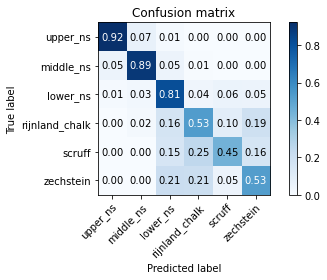

In [16]:
true= finaltrue
truepred= final
precision = precision_score(true, truepred, average='weighted')
recall = recall_score(true, truepred, average='weighted')
f1 = f1_score(true, truepred, average='weighted')
jaccard=jaccard_score(true, truepred, average='weighted')
acc=accuracy_score(true,truepred)


classnames = {0:'upper_ns', 
              1:'middle_ns', 
              2:'lower_ns',
              3:'rijnland_chalk', 
              4:'scruff', 
              5:'zechstein'}
print(f'Acurácia: \t{acc}')

matrix = confusion_matrix(true, truepred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

print(f'Precision: \t{precision}')
print(f'Recall: \t{recall}')
print(f'F1-Score: \t{f1}')
print(f'IOU: \t{jaccard}')
elapsed = timeit.default_timer() - start_time
#print(f'elapsed:  \t {elapsed}')

src.plot_confusion_matrix(matrix, classnames.values(), title="Confusion matrix") 

C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(608, 224, 256)
(32, 32, 32)
(608, 224, 256)
(32, 32, 32)
Acurácia: 	0.7564515350233272
Precision: 	0.86426582274664
Recall: 	0.7564515350233272
F1-Score: 	0.7997502307363621
IOU: 	0.6883506436250009


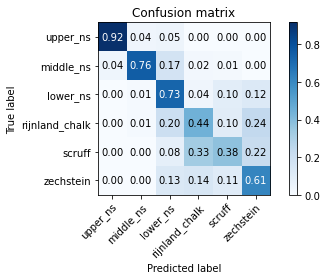

In [4]:
#2,5D my ensemble evaluation

import _init_paths

import fire
import time
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torch.nn.functional as F
import sklearn
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from collections import OrderedDict
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from poc_dataset_ACS import BaseDatasetVoxel
from mylib.loss import soft_cross_entropy_loss
from mylib.utils import MultiAverageMeter, save_model, log_results, to_var, set_seed, \
        to_device, initialize, categorical_to_one_hot, copy_file_backup, redirect_stdout
from poc_config_2dpre import POCVoxelConfig as cfg
from poc_config_2dpre import POCVoxelEnv as env

from unet import UNet
from acsconv.models import ACSUNet
from acsconv.converters import ACSConverter, Conv3dConverter, Conv2_5dConverter

from mylib.metrics import cal_batch_iou, cal_batch_dice, AUROC_per_case
from mylib.loss import soft_dice_loss
from poc_config_2dpre import mergemodels as merge
from unet_ensemble import MyEnsemble
import timeit
start_time = timeit.default_timer()
    
train_data = env.data_train
test_data = env.data_test
eval_data=env.data_eval
eval_data2=env.data_eval2


train_set = BaseDatasetVoxel(train_data, cfg.train_samples)
valid_set = None
test_set = BaseDatasetVoxel(test_data, cfg.test_samples)
eval_set= BaseDatasetVoxel(eval_data, cfg.eval_samples)
eval_set2= BaseDatasetVoxel(eval_data2,cfg.eval_samples2)


PATH=r'C:\Users\admin\Desktop\Elton\F3\ensemblemodels\Conv2_5D\canal_4\model.dat'

model = MyEnsemble()
model.load_state_dict(torch.load(PATH))
model = to_device(model)
true=[]
truepred=[]
test_loader = DataLoader(eval_set2, batch_size=1, shuffle=False,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
from torchvision import models
from torchsummary import summary

#summary(model,(1,32,32,32))
with torch.no_grad():
    for z,(x, y) in enumerate(test_loader):
        x = to_var(x)
        y = to_var(y)
            
        model.eval()
        predit = model(x)
        
        predit, y = predit.detach().cpu().numpy(), y.detach().cpu().numpy() 
        predit=np.argmax(predit,1)
        y=np.argmax(y,1)


        
        truepred.append(predit)
        true.append(y)

import matplotlib.pyplot as plt
import numpy as np
import h5py
import keras
import k3d
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,jaccard_score,accuracy_score
from ipywidgets import interact, widgets

import src
image_size=32
def stuff_patches_3D(out_shape,patches,xstep=image_size,ystep=image_size,zstep=image_size):
    out = np.zeros(out_shape, patches.dtype)
    patch_shape = patches.shape[-3:]
    print(out.shape)
    print(patch_shape)
    patches_6D = np.lib.stride_tricks.as_strided(out, ((out.shape[0]  ) // xstep, (out.shape[1]  ) // ystep,
                                                  (out.shape[2]  ) // zstep, patch_shape[0], patch_shape[1], patch_shape[2]),
                                                  (out.strides[0] * xstep, out.strides[1] * ystep,out.strides[2] * zstep, out.strides[0], out.strides[1],out.strides[2]))
    patches_6D[...] = patches.reshape(patches_6D.shape)
    return out

#test2=(np.load(r'D:\Elton\F3\data\test_once\test2_labels.npy')).shape
test1=(np.load(r'D:\Elton\F3\data\test_once\test2_labels.npy')).shape

pad= tuple((image_size - x%image_size) for x in test1)
test2=np.add(test1,pad)

true= np.concatenate(true).ravel()
truepred= np.concatenate(truepred).ravel()

patches=true.reshape(-1,image_size,image_size,image_size)
patchesensemble=truepred.reshape(-1,image_size,image_size,image_size)

true=stuff_patches_3D((test2),patches)

truepred=stuff_patches_3D((test2),patchesensemble)

true=true[:-pad[0],:-pad[1],:-pad[2]]
truepred=truepred[:-pad[0],:-pad[1],:-pad[2]]

patches=true
patchesensemble=truepred

true= np.concatenate(true).ravel()
truepred= np.concatenate(truepred).ravel()




precision = precision_score(true, truepred, average='weighted')
recall = recall_score(true, truepred, average='weighted')
f1 = f1_score(true, truepred, average='weighted')
jaccard=jaccard_score(true, truepred, average='weighted')
acc=accuracy_score(true,truepred)


classnames = {0:'upper_ns', 
              1:'middle_ns', 
              2:'lower_ns',
              3:'rijnland_chalk', 
              4:'scruff', 
              5:'zechstein'}
print(f'Acurácia: \t{acc}')

matrix = confusion_matrix(true, truepred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

print(f'Precision: \t{precision}')
print(f'Recall: \t{recall}')
print(f'F1-Score: \t{f1}')
print(f'IOU: \t{jaccard}')
elapsed = timeit.default_timer() - start_time
#print(f'elapsed:  \t {elapsed}')

src.plot_confusion_matrix(matrix, classnames.values(), title="Confusion matrix")     

    



Acurácia: 	0.7564515350233272
Precision: 	0.86426582274664
Recall: 	0.7564515350233272
F1-Score: 	0.7997502307363621
IOU: 	0.6883506436250009
elapsed:  	 84.87329359999998


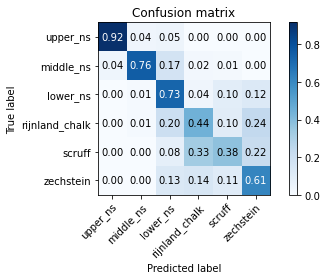

In [5]:
print(f'Acurácia: \t{acc}')
print(f'Precision: \t{precision}')
print(f'Recall: \t{recall}')
print(f'F1-Score: \t{f1}')
print(f'IOU: \t{jaccard}')
elapsed = timeit.default_timer() - start_time
print(f'elapsed:  \t {elapsed}')

src.plot_confusion_matrix(matrix, classnames.values(), title="Confusion matrix")  

In [3]:


truepredensemble1=truepred
true1=true

In [6]:
truepredensemble2=truepred
true2=true

In [7]:
final=np.append(truepredensemble1,truepredensemble2)
finaltrue=np.append(true1,true2)

Acurácia: 	0.8073400349387067
Precision: 	0.8455512364810691
Recall: 	0.8073400349387067
F1-Score: 	0.822304686441338
IOU: 	0.7227988989900713


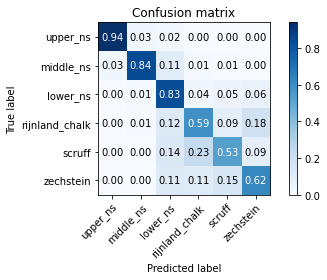

In [8]:
true= finaltrue
truepred= final
precision = precision_score(true, truepred, average='weighted')
recall = recall_score(true, truepred, average='weighted')
f1 = f1_score(true, truepred, average='weighted')
jaccard=jaccard_score(true, truepred, average='weighted')
acc=accuracy_score(true,truepred)


classnames = {0:'upper_ns', 
              1:'middle_ns', 
              2:'lower_ns',
              3:'rijnland_chalk', 
              4:'scruff', 
              5:'zechstein'}
print(f'Acurácia: \t{acc}')

matrix = confusion_matrix(true, truepred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

print(f'Precision: \t{precision}')
print(f'Recall: \t{recall}')
print(f'F1-Score: \t{f1}')
print(f'IOU: \t{jaccard}')
elapsed = timeit.default_timer() - start_time
#print(f'elapsed:  \t {elapsed}')

src.plot_confusion_matrix(matrix, classnames.values(), title="Confusion matrix") 

In [ ]:
seismic_cube = np.load(r'D:\Elton\F3\data\test_once\test2_labels.npy')


image_size=32
pad= tuple((image_size - x%image_size) for x in seismic_cube.shape)
label=np.pad(seismic_cube, ((0,pad[0]),(0,pad[1]),(0,pad[2])), 'edge')
dim= tuple((x//32) for x in label.shape)
dim

In [ ]:
truepred.shape
patchespredunet=truepred.reshape(-1,32,32,32)
patches=true2.reshape(-1,32,32,32)

In [ ]:
pad

In [ ]:
224/32

In [ ]:
seismic_cube = np.load(r'D:\Elton\F3\data\test_once\test1_seismic.npy')
seismic_cube.shape

In [ ]:
fig = plt.figure(figsize=(18,16))
IL=85
ax = fig.add_subplot(131)
sim = ax.imshow(patches[IL,:,:]);
fig.colorbar(sim, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.invert_xaxis()

#ax1 = fig.add_subplot(132)
#amp = ax1.imshow(finalpredunet[:,IL,:]);
#fig.colorbar(amp, ax=ax1)
#ax1.set_xticks([])
#ax1.set_yticks([])
#ax1.invert_xaxis()


ax2 = fig.add_subplot(132)
amp2 = ax2.imshow(patchesensemble[IL,:,:]);
fig.colorbar(amp2, ax=ax2)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.invert_xaxis()

In [ ]:
patches.shape

In [ ]:
b=true.reshape(-1,32,32,32)
b.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x=np.load(r'D:\Elton\F3\data\train_voxel\voxel_203.npz')
y=x['segs']
x=x['voxel']
x.shape,y.shape

In [ ]:
fig = plt.figure(figsize=(10,12))
IL=25
ax = fig.add_subplot(131)
sim = ax.imshow(x[0,IL,:,:]);
fig.colorbar(sim, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.invert_xaxis()

#ax1 = fig.add_subplot(132)
#amp = ax1.imshow(finalpredunet[:,IL,:]);
#fig.colorbar(amp, ax=ax1)
#ax1.set_xticks([])
#ax1.set_yticks([])
#ax1.invert_xaxis()


ax2 = fig.add_subplot(132)
amp2 = ax2.imshow(y[IL,:,:]);
fig.colorbar(amp2, ax=ax2)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.invert_xaxis()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torchsummary import summary


PATH=os.path.join(cfg.save, r'model.dat')
model = UNet(6) #3 é o numero de classes
print(PATH)
model = Conv3dConverter(model)
#initialize(model.modules())
model.load_state_dict(torch.load(PATH))
model = to_device(model)
summary(model, input_size=(2, 32, 32,32))

D:\Elton\F3\Conv3D_399samples\model.dat


C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 128, 32, 32, 32]          44,032
       BatchNorm3d-2      [-1, 128, 32, 32, 32]             256
              ReLU-3      [-1, 128, 32, 32, 32]               0
            Conv3d-4      [-1, 128, 32, 32, 32]       2,809,984
       BatchNorm3d-5      [-1, 128, 32, 32, 32]             256
              ReLU-6      [-1, 128, 32, 32, 32]               0
         MaxPool3d-7      [-1, 128, 16, 16, 16]               0
     _EncoderBlock-8      [-1, 128, 16, 16, 16]               0
            Conv3d-9      [-1, 256, 16, 16, 16]       5,619,968
      BatchNorm3d-10      [-1, 256, 16, 16, 16]             512
             ReLU-11      [-1, 256, 16, 16, 16]               0
           Conv3d-12      [-1, 256, 16, 16, 16]      11,239,680
      BatchNorm3d-13      [-1, 256, 16, 16, 16]             512
             ReLU-14      [-1, 256, 16,

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from unet_ensemble import MyEnsemble
from torchsummary import summary
PATH=r'C:\Users\admin\Desktop\Elton\F3\ensemblemodels\Conv2_5D\canal_4\model.dat'

model = MyEnsemble()
model.load_state_dict(torch.load(PATH))
model = to_device(model)
summary(model, input_size=(2, 32, 32,32))

C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 128, 32, 32, 32]           6,400
       BatchNorm3d-2      [-1, 128, 32, 32, 32]             256
              ReLU-3      [-1, 128, 32, 32, 32]               0
            Conv3d-4      [-1, 128, 32, 32, 32]         401,536
       BatchNorm3d-5      [-1, 128, 32, 32, 32]             256
              ReLU-6      [-1, 128, 32, 32, 32]               0
         MaxPool3d-7      [-1, 128, 16, 16, 16]               0
     _EncoderBlock-8      [-1, 128, 16, 16, 16]               0
            Conv3d-9      [-1, 256, 16, 16, 16]         803,072
      BatchNorm3d-10      [-1, 256, 16, 16, 16]             512
             ReLU-11      [-1, 256, 16, 16, 16]               0
           Conv3d-12      [-1, 256, 16, 16, 16]       1,605,888
      BatchNorm3d-13      [-1, 256, 16, 16, 16]             512
             ReLU-14      [-1, 256, 16,